In [328]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

sns.set_palette('Set2')
%matplotlib inline

In [329]:
#endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#res = requests.get(endpoint + '?fsym=LTC&tsym=USD&limit=2000&date=2022-02-23&api_key=6a31e60d1528d9d9dafb1faa2540af41393829b6c1f9fc495e5df6fe553a9fa8')
res = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000&toTs=1614124800&api_key=6a31e60d1528d9d9dafb1faa2540af41393829b6c1f9fc495e5df6fe553a9fa8')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist = hist.drop(columns="conversionType")
hist = hist.drop(columns="conversionSymbol")
hist.index = pd.to_datetime(hist.index, unit='s')

In [330]:
hist.tail()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-02-20,57528.16,54140.61,55933.47,52924.57,2.974873e+09,55900.84
2021-02-21,58348.75,55516.07,55900.84,33823.01,1.934006e+09,57469.95
2021-02-22,57540.74,48194.31,57469.95,130806.33,6.995162e+09,54121.17
2021-02-23,54164.35,44983.39,54121.17,165758.08,8.016451e+09,48898.70
2021-02-24,51399.55,47015.55,48898.70,58773.17,2.933868e+09,49682.51


In [331]:
target_col = 'close'

In [332]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [333]:
train, test = train_test_split(hist, test_size=0.1)

## Plot data

In [334]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

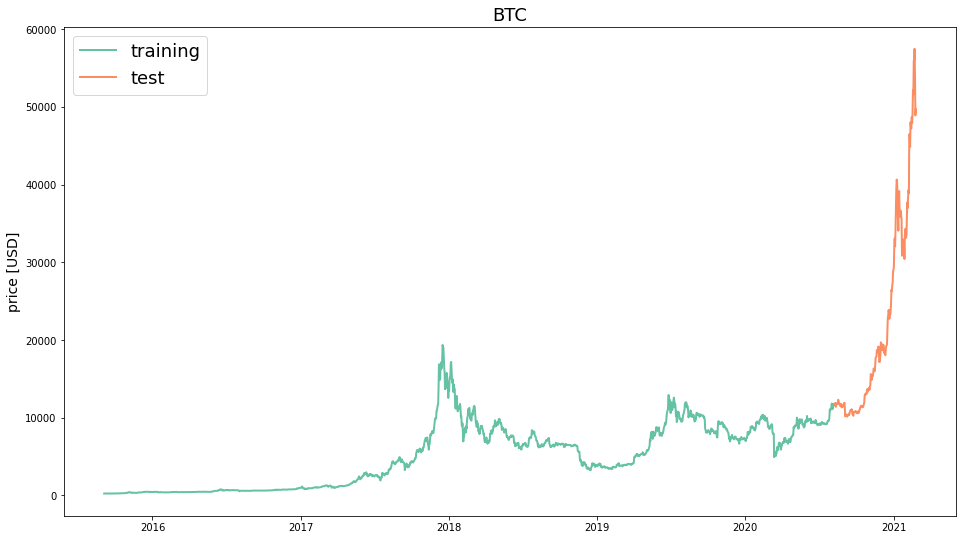

In [335]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC')

## LSTM

In [336]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    print(df.iloc[0])
    return df / df.iloc[0]

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

In [337]:
def extract_window_data(df, window_len=10, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [338]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
 
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [339]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [340]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [341]:

train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

high               231.06
low                225.75
open               226.20
volumefrom       61762.93
volumeto      14174313.31
close              230.25
Name: 2015-09-04 00:00:00, dtype: float64
high               235.61
low                228.29
open               230.25
volumefrom       48280.18
volumeto      11253257.52
close              233.67
Name: 2015-09-05 00:00:00, dtype: float64
high               243.64
low                234.74
open               233.67
volumefrom       66271.08
volumeto      15939620.21
close              239.86
Name: 2015-09-06 00:00:00, dtype: float64
high               242.66
low                237.49
open               239.86
volumefrom       57187.93
volumeto      13744695.27
close              239.58
Name: 2015-09-07 00:00:00, dtype: float64
high               246.38
low                239.23
open               239.58
volumefrom       76353.97
volumeto      18605471.98
close              243.24
Name: 2015-09-08 00:00:00, dtype: float64
high      

Name: 2016-02-20 00:00:00, dtype: float64
high               447.61
low                425.47
open               440.06
volumefrom      100499.03
volumeto      44120520.96
close              437.87
Name: 2016-02-21 00:00:00, dtype: float64
high               440.18
low                431.30
open               437.87
volumefrom       56010.22
volumeto      24563748.20
close              437.79
Name: 2016-02-22 00:00:00, dtype: float64
high               440.76
low                414.36
open               437.79
volumefrom       93717.62
volumeto      39915706.29
close              419.90
Name: 2016-02-23 00:00:00, dtype: float64
high               425.17
low                410.36
open               419.90
volumefrom       66506.84
volumeto      28041199.85
close              422.72
Name: 2016-02-24 00:00:00, dtype: float64
high               427.18
low                417.51
open               422.72
volumefrom       53541.45
volumeto      22692099.41
close              423.48
Name: 2016

Name: 2016-07-20 00:00:00, dtype: float64
high               666.51
low                657.82
open               664.40
volumefrom       32164.64
volumeto      21351309.78
close              664.62
Name: 2016-07-21 00:00:00, dtype: float64
high               669.44
low                645.69
open               664.62
volumefrom       65894.84
volumeto      43283429.35
close              651.11
Name: 2016-07-22 00:00:00, dtype: float64
high               658.17
low                647.98
open               651.11
volumefrom       29884.68
volumeto      19544654.54
close              655.16
Name: 2016-07-23 00:00:00, dtype: float64
high               664.21
low                651.03
open               655.16
volumefrom       29815.62
volumeto      19642346.73
close              659.29
Name: 2016-07-24 00:00:00, dtype: float64
high               662.51
low                651.08
open               659.29
volumefrom       34383.06
volumeto      22564554.46
close              654.00
Name: 2016

Name: 2017-01-02 00:00:00, dtype: float64
high              1035.47
low               1006.53
open              1017.05
volumefrom       54788.01
volumeto      56085870.70
close             1033.30
Name: 2017-01-03 00:00:00, dtype: float64
high          1.148540e+03
low           1.022320e+03
open          1.033300e+03
volumefrom    1.562722e+05
volumeto      1.705846e+08
close         1.135410e+03
Name: 2017-01-04 00:00:00, dtype: float64
high          1.150630e+03
low           8.745300e+02
open          1.135410e+03
volumefrom    2.400078e+05
volumeto      2.448393e+08
close         9.893500e+02
Name: 2017-01-05 00:00:00, dtype: float64
high          1.027420e+03
low           8.525500e+02
open          9.893500e+02
volumefrom    1.942910e+05
volumeto      1.791607e+08
close         8.861600e+02
Name: 2017-01-06 00:00:00, dtype: float64
high          9.008600e+02
low           8.066600e+02
open          8.861600e+02
volumefrom    1.306631e+05
volumeto      1.130375e+08
close        

Name: 2017-06-17 00:00:00, dtype: float64
high          2.676040e+03
low           2.488590e+03
open          2.655100e+03
volumefrom    9.200422e+04
volumeto      2.352393e+08
close         2.539560e+03
Name: 2017-06-18 00:00:00, dtype: float64
high          2.617750e+03
low           2.518780e+03
open          2.539560e+03
volumefrom    8.182922e+04
volumeto      2.103728e+08
close         2.616820e+03
Name: 2017-06-19 00:00:00, dtype: float64
high          2.800480e+03
low           2.613980e+03
open          2.616820e+03
volumefrom    1.113036e+05
volumeto      3.000340e+08
close         2.754380e+03
Name: 2017-06-20 00:00:00, dtype: float64
high          2.804410e+03
low           2.624350e+03
open          2.754380e+03
volumefrom    1.160336e+05
volumeto      3.132347e+08
close         2.677620e+03
Name: 2017-06-21 00:00:00, dtype: float64
high          2.757320e+03
low           2.623170e+03
open          2.677620e+03
volumefrom    7.829760e+04
volumeto      2.103188e+08
close  

Name: 2017-11-25 00:00:00, dtype: float64
high          9.474620e+03
low           8.746560e+03
open          8.754620e+03
volumefrom    8.589198e+04
volumeto      7.825000e+08
close         9.318420e+03
Name: 2017-11-26 00:00:00, dtype: float64
high          9.733610e+03
low           9.316840e+03
open          9.318420e+03
volumefrom    1.069028e+05
volumeto      1.025176e+09
close         9.733200e+03
Name: 2017-11-27 00:00:00, dtype: float64
high          9.969580e+03
low           9.638200e+03
open          9.732630e+03
volumefrom    8.775489e+04
volumeto      8.653286e+08
close         9.906040e+03
Name: 2017-11-28 00:00:00, dtype: float64
high          1.141784e+04
low           8.938700e+03
open          9.906040e+03
volumefrom    2.333253e+05
volumeto      2.418792e+09
close         9.837860e+03
Name: 2017-11-29 00:00:00, dtype: float64
high          1.068906e+04
low           9.023770e+03
open          9.848050e+03
volumefrom    1.870089e+05
volumeto      1.836210e+09
close  

Name: 2018-04-26 00:00:00, dtype: float64
high          9.385870e+03
low           8.923480e+03
open          9.289010e+03
volumefrom    8.202540e+04
volumeto      7.581824e+08
close         8.938470e+03
Name: 2018-04-27 00:00:00, dtype: float64
high          9.435900e+03
low           8.892520e+03
open          8.938470e+03
volumefrom    8.334710e+04
volumeto      7.741117e+08
close         9.351470e+03
Name: 2018-04-28 00:00:00, dtype: float64
high          9.552670e+03
low           9.189070e+03
open          9.349940e+03
volumefrom    6.822703e+04
volumeto      6.409319e+08
close         9.407040e+03
Name: 2018-04-29 00:00:00, dtype: float64
high          9.459810e+03
low           9.133600e+03
open          9.407350e+03
volumefrom    6.163136e+04
volumeto      5.740992e+08
close         9.248450e+03
Name: 2018-04-30 00:00:00, dtype: float64
high          9.251660e+03
low           8.851100e+03
open          9.248250e+03
volumefrom    7.414780e+04
volumeto      6.695554e+08
close  

Name: 2018-09-30 00:00:00, dtype: float64
high          6.662600e+03
low           6.510540e+03
open          6.623820e+03
volumefrom    3.892698e+04
volumeto      2.569599e+08
close         6.594980e+03
Name: 2018-10-01 00:00:00, dtype: float64
high          6.618950e+03
low           6.478040e+03
open          6.594980e+03
volumefrom    4.062420e+04
volumeto      2.671663e+08
close         6.525470e+03
Name: 2018-10-02 00:00:00, dtype: float64
high          6.537070e+03
low           6.428980e+03
open          6.525460e+03
volumefrom    4.718600e+04
volumeto      3.063853e+08
close         6.492260e+03
Name: 2018-10-03 00:00:00, dtype: float64
high          6.622320e+03
low           6.486860e+03
open          6.492610e+03
volumefrom    4.214296e+04
volumeto      2.776140e+08
close         6.579790e+03
Name: 2018-10-04 00:00:00, dtype: float64
high          6.683550e+03
low           6.546980e+03
open          6.580000e+03
volumefrom    3.973128e+04
volumeto      2.625623e+08
close  

Name: 2019-03-07 00:00:00, dtype: float64
high          3.932020e+03
low           3.804980e+03
open          3.882610e+03
volumefrom    3.942825e+04
volumeto      1.534051e+08
close         3.868020e+03
Name: 2019-03-08 00:00:00, dtype: float64
high          3.975250e+03
low           3.860660e+03
open          3.868020e+03
volumefrom    2.760001e+04
volumeto      1.083702e+08
close         3.947740e+03
Name: 2019-03-09 00:00:00, dtype: float64
high              3948.21
low               3897.82
open              3947.74
volumefrom       17404.16
volumeto      68252920.53
close             3929.84
Name: 2019-03-10 00:00:00, dtype: float64
high          3.941990e+03
low           3.849450e+03
open          3.929840e+03
volumefrom    3.270855e+04
volumeto      1.269986e+08
close         3.874890e+03
Name: 2019-03-11 00:00:00, dtype: float64
high          3.904700e+03
low           3.827230e+03
open          3.874890e+03
volumefrom    3.365537e+04
volumeto      1.302916e+08
close        

Name: 2019-08-13 00:00:00, dtype: float64
high          1.087344e+04
low           9.924580e+03
open          1.087200e+04
volumefrom    7.012586e+04
volumeto      7.282475e+08
close         1.003189e+04
Name: 2019-08-14 00:00:00, dtype: float64
high          1.045161e+04
low           9.497120e+03
open          1.003189e+04
volumefrom    8.443815e+04
volumeto      8.429791e+08
close         1.030851e+04
Name: 2019-08-15 00:00:00, dtype: float64
high          1.054497e+04
low           9.764320e+03
open          1.030851e+04
volumefrom    6.235748e+04
volumeto      6.350408e+08
close         1.036043e+04
Name: 2019-08-16 00:00:00, dtype: float64
high          1.047464e+04
low           1.001076e+04
open          1.036043e+04
volumefrom    2.447079e+04
volumeto      2.510183e+08
close         1.022075e+04
Name: 2019-08-17 00:00:00, dtype: float64
high          1.051289e+04
low           1.007946e+04
open          1.022075e+04
volumefrom    2.161415e+04
volumeto      2.234562e+08
close  

Name: 2020-01-16 00:00:00, dtype: float64
high          9.004350e+03
low           8.665990e+03
open          8.719630e+03
volumefrom    4.878740e+04
volumeto      4.328564e+08
close         8.894830e+03
Name: 2020-01-17 00:00:00, dtype: float64
high          8.974650e+03
low           8.807260e+03
open          8.894830e+03
volumefrom    1.987290e+04
volumeto      1.768374e+08
close         8.909280e+03
Name: 2020-01-18 00:00:00, dtype: float64
high          9.177390e+03
low           8.508150e+03
open          8.909280e+03
volumefrom    4.775090e+04
volumeto      4.214833e+08
close         8.702590e+03
Name: 2020-01-19 00:00:00, dtype: float64
high          8.737360e+03
low           8.521520e+03
open          8.702590e+03
volumefrom    2.188847e+04
volumeto      1.892474e+08
close         8.634030e+03
Name: 2020-01-20 00:00:00, dtype: float64
high          8.771750e+03
low           8.479900e+03
open          8.634030e+03
volumefrom    2.273119e+04
volumeto      1.964045e+08
close  

Name: 2020-06-28 00:00:00, dtype: float64
high          9.234330e+03
low           9.026420e+03
open          9.120390e+03
volumefrom    3.111919e+04
volumeto      2.837649e+08
close         9.187070e+03
Name: 2020-06-29 00:00:00, dtype: float64
high          9.200990e+03
low           9.068770e+03
open          9.187070e+03
volumefrom    2.337663e+04
volumeto      2.139055e+08
close         9.136470e+03
Name: 2020-06-30 00:00:00, dtype: float64
high          9.299670e+03
low           9.097330e+03
open          9.136470e+03
volumefrom    2.984640e+04
volumeto      2.748350e+08
close         9.238890e+03
Name: 2020-07-01 00:00:00, dtype: float64
high          9.267840e+03
low           8.954670e+03
open          9.238890e+03
volumefrom    3.765749e+04
volumeto      3.434334e+08
close         9.092800e+03
Name: 2020-07-02 00:00:00, dtype: float64
high          9.127050e+03
low           9.047380e+03
open          9.092800e+03
volumefrom    2.180746e+04
volumeto      1.984281e+08
close  

Name: 2020-12-07 00:00:00, dtype: float64
high          1.929538e+04
low           1.822731e+04
open          1.918141e+04
volumefrom    4.615165e+04
volumeto      8.665434e+08
close         1.832352e+04
Name: 2020-12-08 00:00:00, dtype: float64
high          1.863924e+04
low           1.766915e+04
open          1.832352e+04
volumefrom    5.799745e+04
volumeto      1.057335e+09
close         1.854992e+04
Name: 2020-12-09 00:00:00, dtype: float64
high          1.855432e+04
low           1.792056e+04
open          1.854992e+04
volumefrom    3.750096e+04
volumeto      6.848028e+08
close         1.825047e+04
Name: 2020-12-10 00:00:00, dtype: float64
high          1.829510e+04
low           1.759813e+04
open          1.825047e+04
volumefrom    4.516617e+04
volumeto      8.093189e+08
close         1.803486e+04
Name: 2020-12-11 00:00:00, dtype: float64
high          1.894878e+04
low           1.803305e+04
open          1.803486e+04
volumefrom    2.615036e+04
volumeto      4.842395e+08
close  

In [342]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

#X_train = np.asarray(X_train).astype(np.float32)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
449/449 [==============================] - 2s 2ms/step - loss: 0.1317
Epoch 2/50
449/449 [==============================] - 1s 2ms/step - loss: 0.0648
Epoch 3/50
449/449 [==============================] - 1s 2ms/step - loss: 0.0570
Epoch 4/50
449/449 [==============================] - 1s 2ms/step - loss: 0.0496
Epoch 5/50
449/449 [==============================] - 1s 2ms/step - loss: 0.0508
Epoch 6/50
449/449 [==============================] - 1s 2ms/step - loss: 0.0437
Epoch 7/50
449/449 [==============================] - 1s 2ms/step - loss: 0.0445
Epoch 8/50
449/449 [==============================] - 1s 2ms/step - loss: 0.0434
Epoch 9/50
449/449 [==============================] - 1s 2ms/step - loss: 0.0397
Epoch 10/50
449/449 [==============================] - 1s 2ms/step - loss: 0.0388
Epoch 11/50
449/449 [==============================] - 1s 2ms/step - loss: 0.0395
Epoch 12/50
449/449 [==============================] - 1s 2ms/step - loss: 0.0372
Epoch 13/50
449/449 [====

## Plot predictions

In [343]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

In [344]:
mean_absolute_error(preds, y_test)

0.03231835557762261

In [345]:
# 0.045261384613638447 with mae

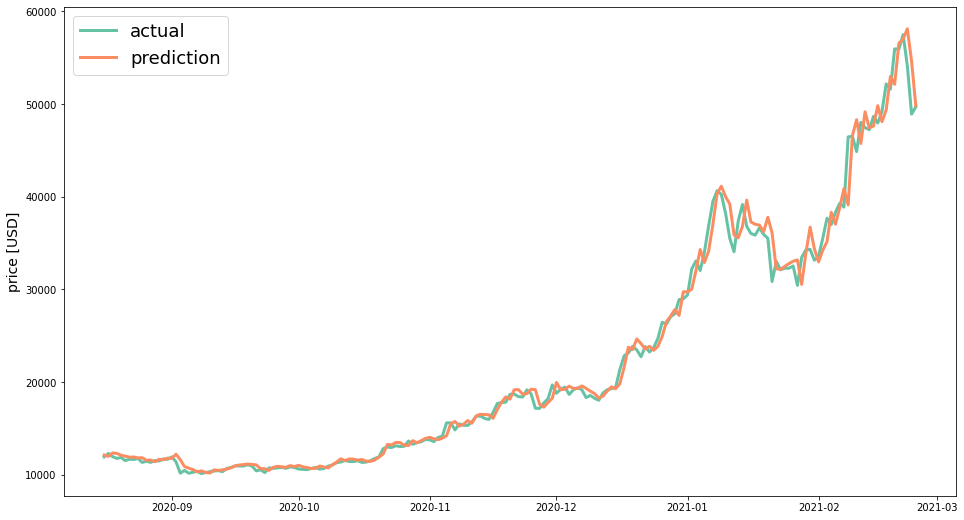

In [346]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)

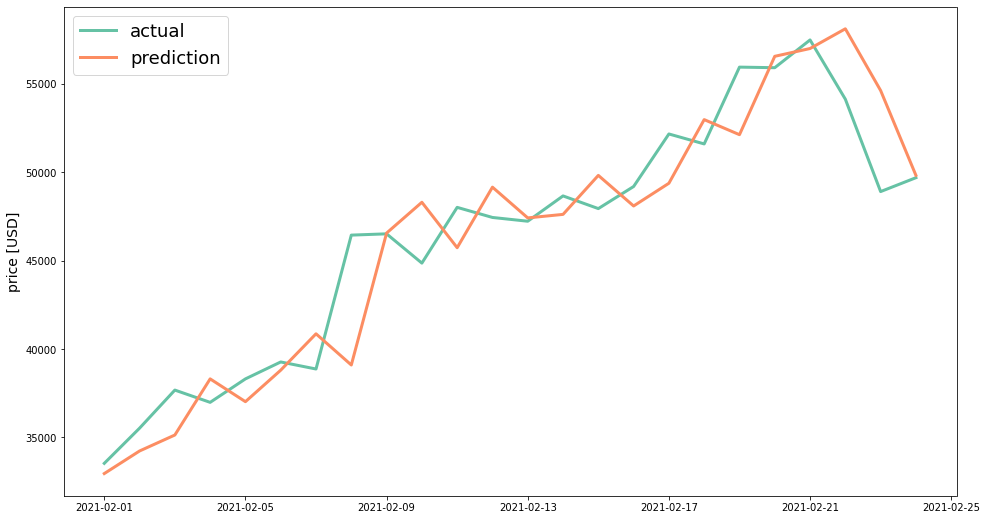

In [360]:
n_points = 24

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

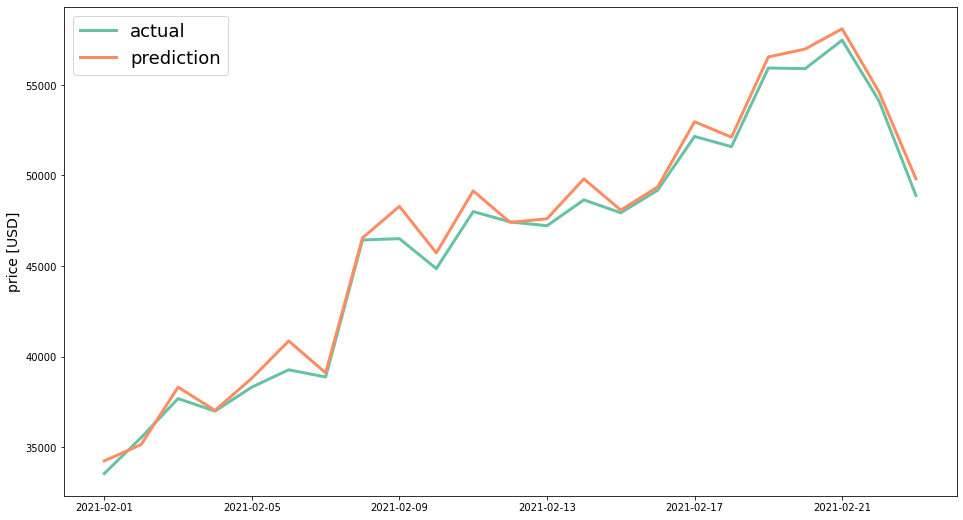

In [359]:
line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction', lw=3)

## Compare returns

In [349]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

In [350]:
def dual_line_plot(line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw)
    ax1.plot(line2, label=label2, linewidth=lw)
    ax2.plot(line3, label=label1, linewidth=lw)
    ax2.plot(line4, label=label2, linewidth=lw)
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

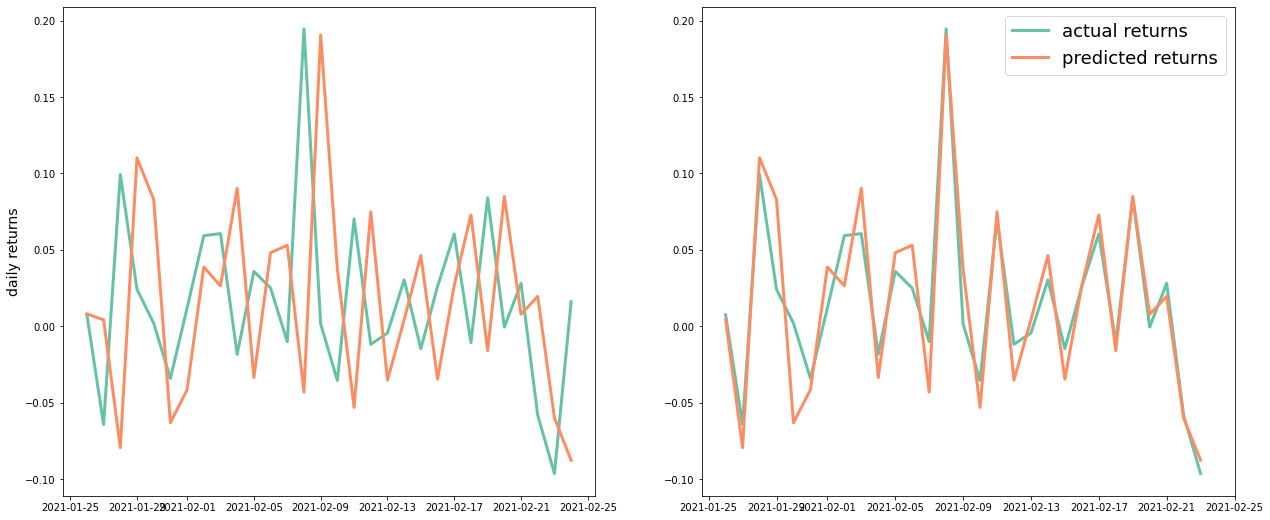

In [351]:
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=3)

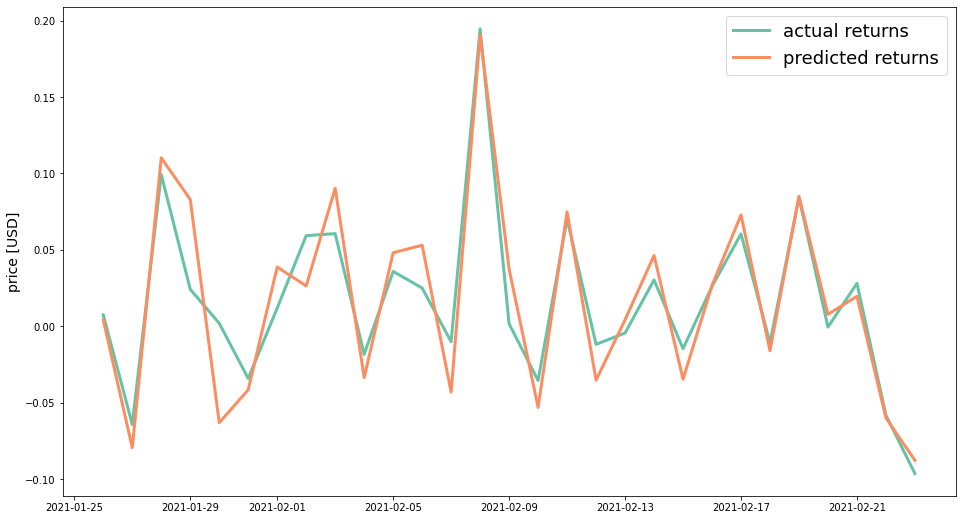

In [352]:
line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns', lw=3)

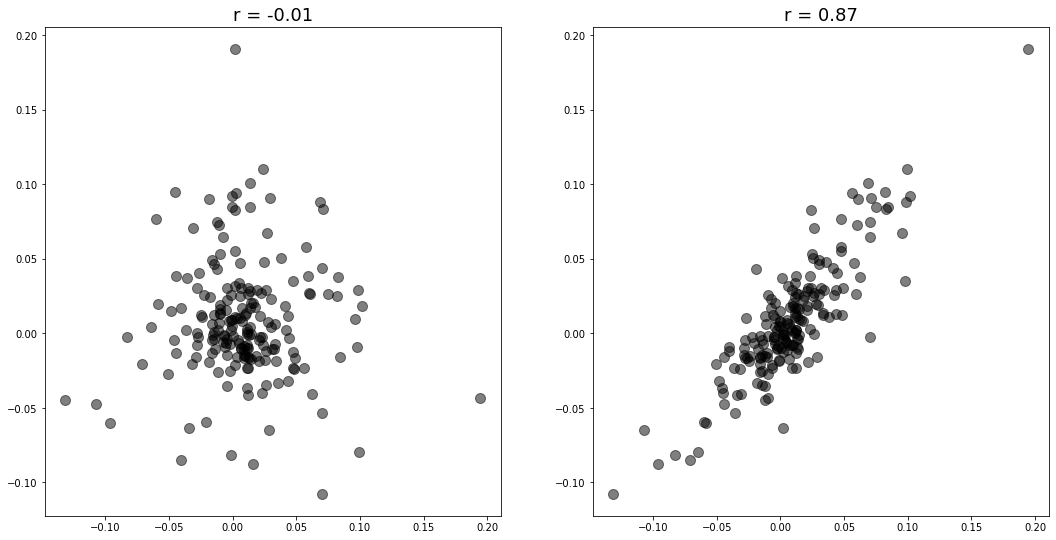

In [353]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('r = {:.2f}'.format(corr), fontsize=18);